In [3]:
import pandas as pd

data = pd.read_csv("final_data.csv")
data['DATE'] = pd.to_datetime(data['DATE']) 

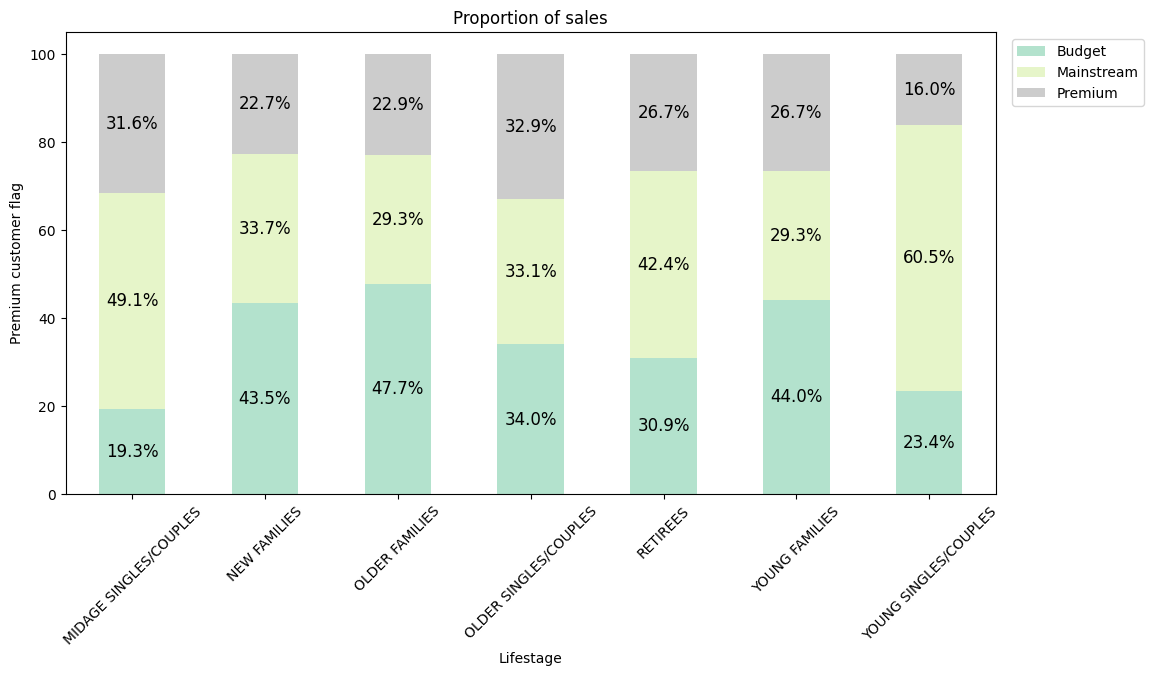

In [33]:
# Aggregate total sales by LIFESTAGE and PREMIUM_CUSTOMER

import matplotlib.pyplot as plt
import seaborn as sns


sales = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()

sales['Total_Lifestage_Sales'] = sales.groupby('LIFESTAGE')['TOT_SALES'].transform('sum')
sales['Proportion'] = sales['TOT_SALES'] / sales['Total_Lifestage_Sales'] * 100

pivot_sales = sales.pivot(index="LIFESTAGE", columns="PREMIUM_CUSTOMER", values="Proportion").fillna(0)


fig, ax = plt.subplots(figsize=(12, 6))
pivot_sales.plot(kind='bar', stacked=True, colormap="Pastel2", ax=ax)


for i, lifestage in enumerate(pivot_sales.index):
    bottom = 0
    for category in pivot_sales.columns:
        proportion = pivot_sales.loc[lifestage, category]
        if proportion > 0:
            ax.text(i, bottom + proportion / 2, f"{proportion:.1f}%", ha="center", va="center", fontsize=12, color="black")
            bottom += proportion


ax.set_xlabel("Lifestage")
ax.set_ylabel("Premium customer flag")
ax.set_title("Proportion of sales")
plt.xticks(rotation=45)
plt.legend(loc="upper left",bbox_to_anchor=(1.01, 1) )

plt.show()




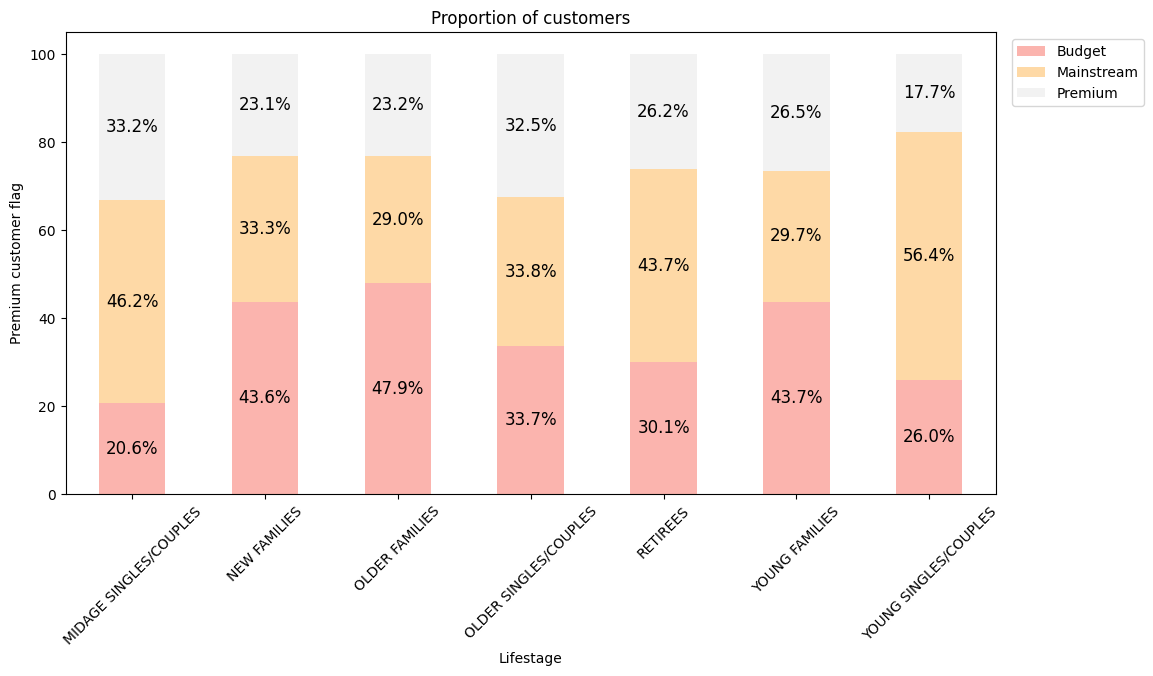

In [ ]:
# Aggregate number of unique customers by LIFESTAGE and PREMIUM_CUSTOMER

customers = (data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])
                .agg(CUSTOMERS=('LYLTY_CARD_NBR', pd.Series.nunique))
                .reset_index())

customers['Total_Lifestage_Customers'] = customers.groupby('LIFESTAGE')['CUSTOMERS'].transform('sum')
customers['Proportion'] = customers['CUSTOMERS'] / customers['Total_Lifestage_Customers'] * 100


pivot_customers = customers.pivot(index="LIFESTAGE", columns="PREMIUM_CUSTOMER", values="Proportion").fillna(0)


fig, ax = plt.subplots(figsize=(12, 6))
pivot_customers.plot(kind='bar', stacked=True, colormap="Pastel1", ax=ax)


for i, lifestage in enumerate(pivot_customers.index):
    bottom = 0
    for category in pivot_customers.columns:
        proportion = pivot_customers.loc[lifestage, category]
        if proportion > 0:
            ax.text(i, bottom + proportion / 2, f"{proportion:.1f}%", ha="center", va="center", fontsize=12, color="black")
            bottom += proportion


ax.set_xlabel("Lifestage")
ax.set_ylabel("Premium customer flag")
ax.set_title("Proportion of customers")
plt.xticks(rotation=45)
plt.legend(loc="upper left", bbox_to_anchor=(1.01, 1))


plt.show()


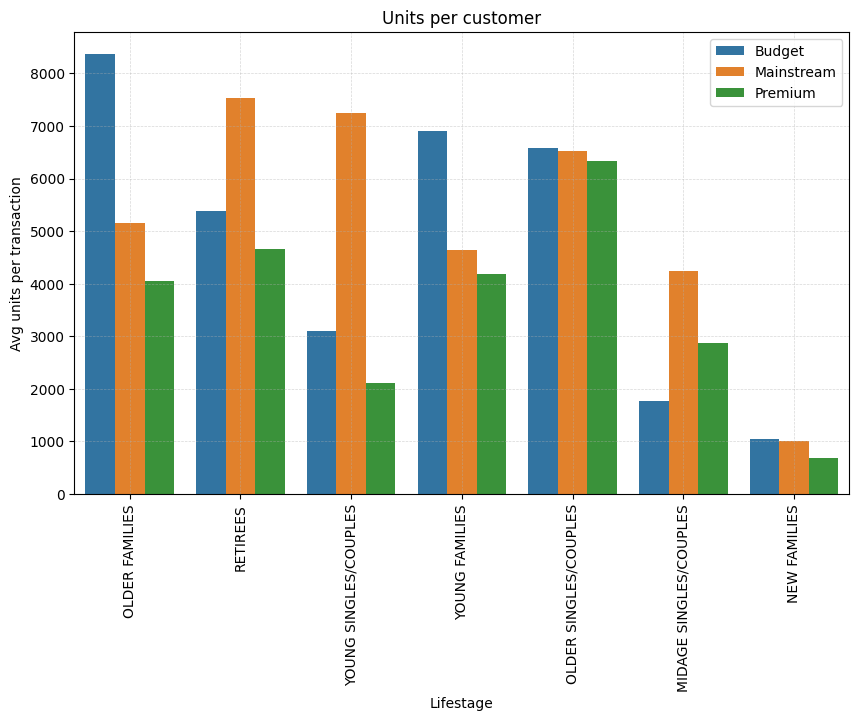

In [4]:
# Average number of units per customer
avg_units = (data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])
                .agg(AVG=('PROD_QTY', lambda x: x.sum() / x.nunique()))
                .reset_index()
                .sort_values(by='AVG', ascending=False))


plt.figure(figsize=(10, 6))
sns.barplot(data=avg_units, x='LIFESTAGE', y='AVG', hue='PREMIUM_CUSTOMER')
plt.xticks(rotation=90)
plt.xlabel("Lifestage")
plt.ylabel("Avg units per transaction")
plt.title("Units per customer")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
plt.show()

In [13]:
# Let’s find out if Mainstream - young singles/couples tend to buy a particular brand of chips.

segment1 = data[(data['LIFESTAGE'] == "YOUNG SINGLES/COUPLES") & (data['PREMIUM_CUSTOMER'] == "Mainstream")]
other = data[~((data['LIFESTAGE'] == "YOUNG SINGLES/COUPLES") & (data['PREMIUM_CUSTOMER'] == "Mainstream"))]

quantity_segment1 = segment1['PROD_QTY'].sum()
quantity_other = other['PROD_QTY'].sum()

# Calculating brand affinity
quantity_segment1_by_brand = segment1.groupby('BRAND')['PROD_QTY'].sum().reset_index()
quantity_segment1_by_brand['targetSegment'] = quantity_segment1_by_brand['PROD_QTY'] / quantity_segment1

quantity_other_by_brand = other.groupby('BRAND')['PROD_QTY'].sum().reset_index()
quantity_other_by_brand['other'] = quantity_other_by_brand['PROD_QTY'] / quantity_other

# Merging and calculating brand affinity ratio
brand_proportions = pd.merge(quantity_segment1_by_brand[['BRAND', 'targetSegment']],
                             quantity_other_by_brand[['BRAND', 'other']], on='BRAND', how='inner')
brand_proportions['affinityToBrand'] = brand_proportions['targetSegment'] / brand_proportions['other']


brand_proportions = brand_proportions.sort_values(by='affinityToBrand', ascending=False)

print(brand_proportions)

         BRAND  targetSegment     other  affinityToBrand
18    TYRRELLS       0.031553  0.025692         1.228095
17    TWISTIES       0.046184  0.037877         1.219319
5      DORITOS       0.122761  0.101075         1.214553
9       KETTLE       0.197985  0.165553         1.195897
16    TOSTITOS       0.045411  0.037978         1.195713
11    PRINGLES       0.119420  0.100635         1.186670
4         COBS       0.044638  0.039049         1.143124
8    INFUZIONS       0.064679  0.057065         1.133435
15       THINS       0.060373  0.056986         1.059423
7      GRNWVES       0.032712  0.031188         1.048873
3     CHEEZELS       0.017971  0.018647         0.963753
13      SMITHS       0.096370  0.124584         0.773536
6       FRENCH       0.003948  0.005758         0.685569
2      CHEETOS       0.008033  0.012067         0.665733
12         RRD       0.043810  0.067494         0.649091
10     NATURAL       0.019600  0.030854         0.635241
1          CCS       0.011180  

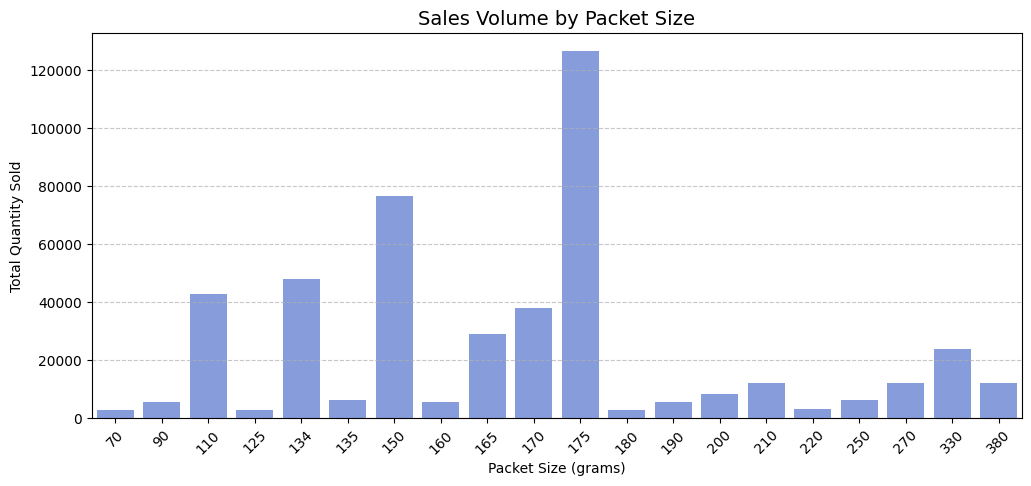

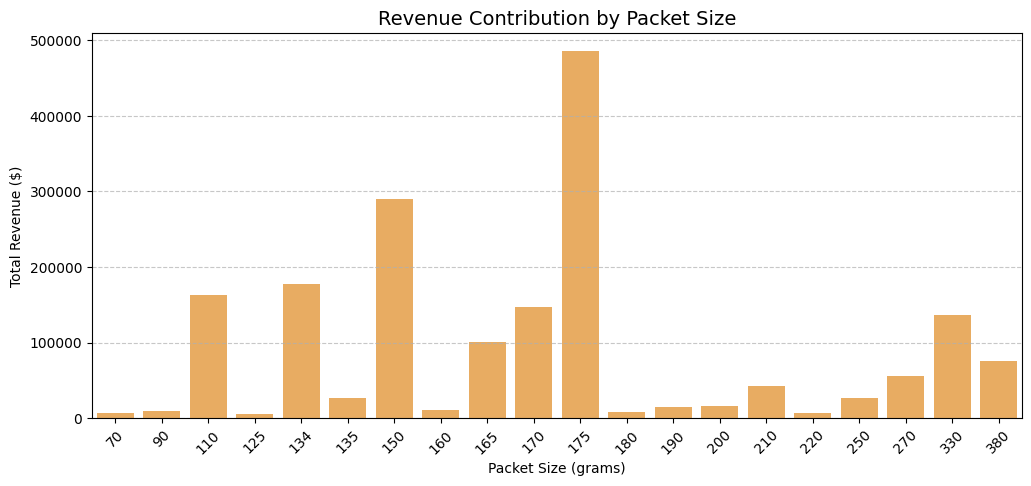

In [ ]:
# Aggregate total sales and total quantity sold by packet size
sales_by_pack = data.groupby("PACK_SIZE").agg({
    "TOT_SALES": "sum",  # Total revenue per packet size
    "PROD_QTY": "sum"    # Total quantity sold per packet size
}).reset_index()


# First Graph: Sales Volume by Packet Size
plt.figure(figsize=(12, 5))
sns.barplot(x=sales_by_pack["PACK_SIZE"], y=sales_by_pack["PROD_QTY"], color="royalblue", alpha=0.7)
plt.title("Sales Volume by Packet Size", fontsize=14)
plt.xlabel("Packet Size (grams)")
plt.ylabel("Total Quantity Sold")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Second Graph: Revenue Contribution by Packet Size
plt.figure(figsize=(12, 5))
sns.barplot(x=sales_by_pack["PACK_SIZE"], y=sales_by_pack["TOT_SALES"], color="darkorange", alpha=0.7)
plt.title("Revenue Contribution by Packet Size", fontsize=14)
plt.xlabel("Packet Size (grams)")
plt.ylabel("Total Revenue ($)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

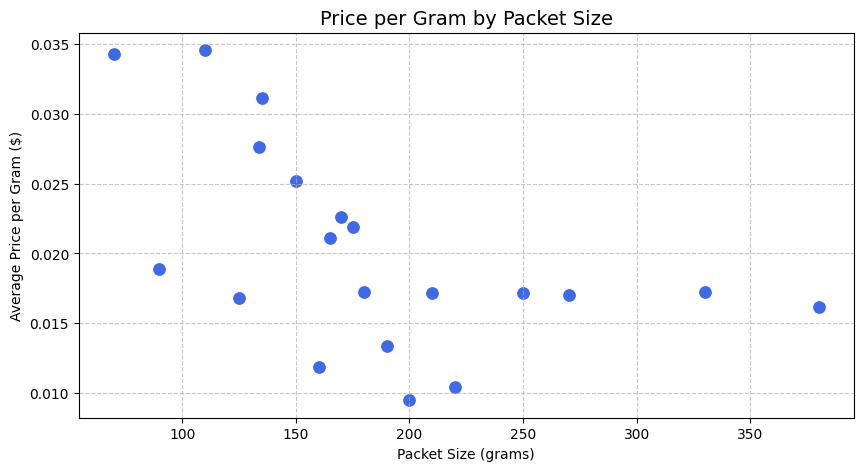

In [ ]:
# Calculate price per gram (total sales divided by total grams sold)
data["PRICE_PER_GRAM"] = data["TOT_SALES"] / (data["PACK_SIZE"] * data["PROD_QTY"])

# Aggregate price per gram and sales volume per packet size
price_elasticity = data.groupby("PACK_SIZE").agg({
    "PRICE_PER_GRAM": "mean",  # Average price per gram for each packet size
    "PROD_QTY": "sum"          # Total quantity sold for each packet size
}).reset_index()



# Graph: Price per Gram vs Packet Size
plt.figure(figsize=(10, 5))
sns.scatterplot(x=price_elasticity["PACK_SIZE"], y=price_elasticity["PRICE_PER_GRAM"], color="royalblue", s=100)
plt.title("Price per Gram by Packet Size", fontsize=14)
plt.xlabel("Packet Size (grams)")
plt.ylabel("Average Price per Gram ($)")
plt.grid(axis="both", linestyle="--", alpha=0.7)
plt.show()


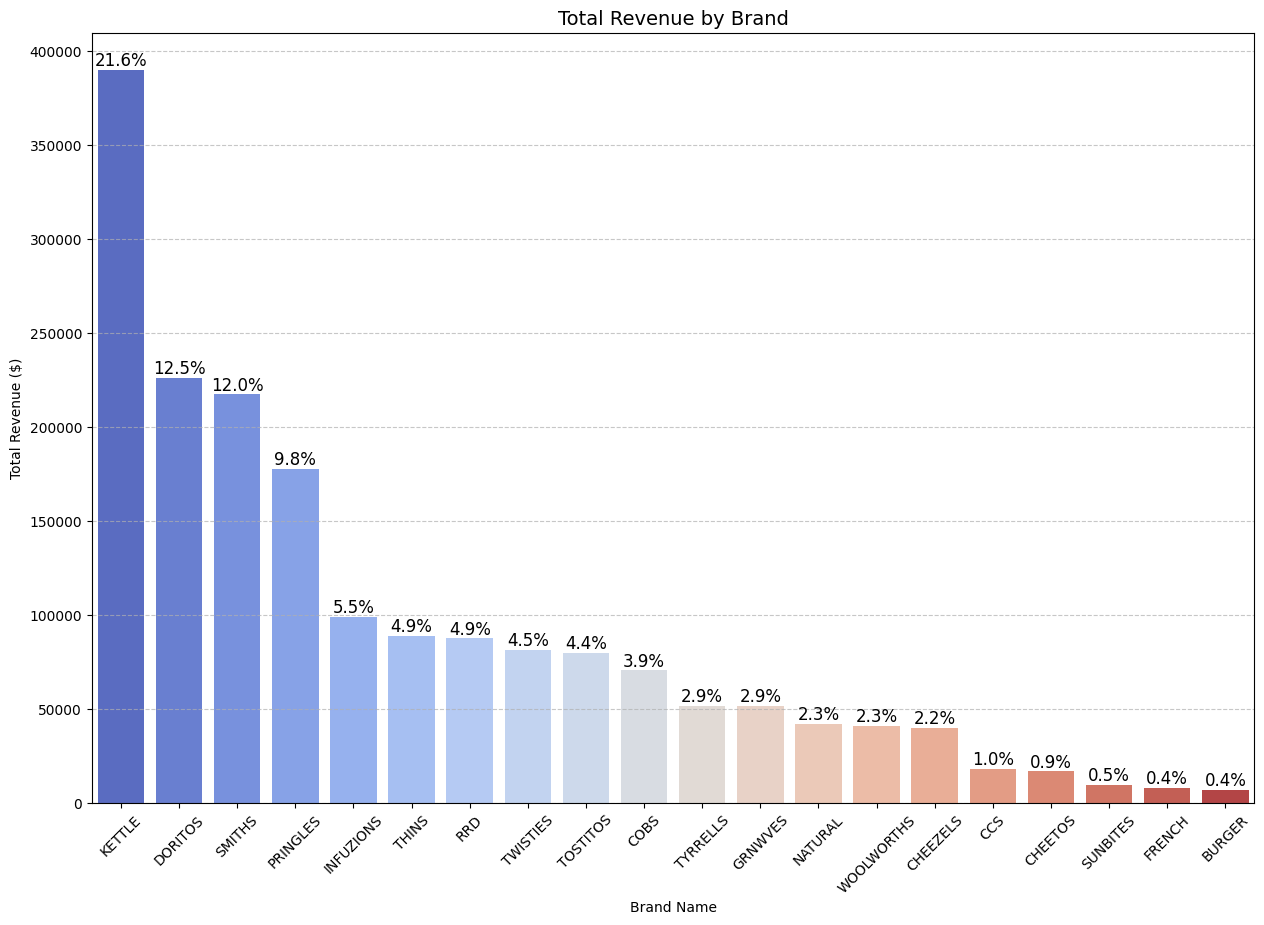

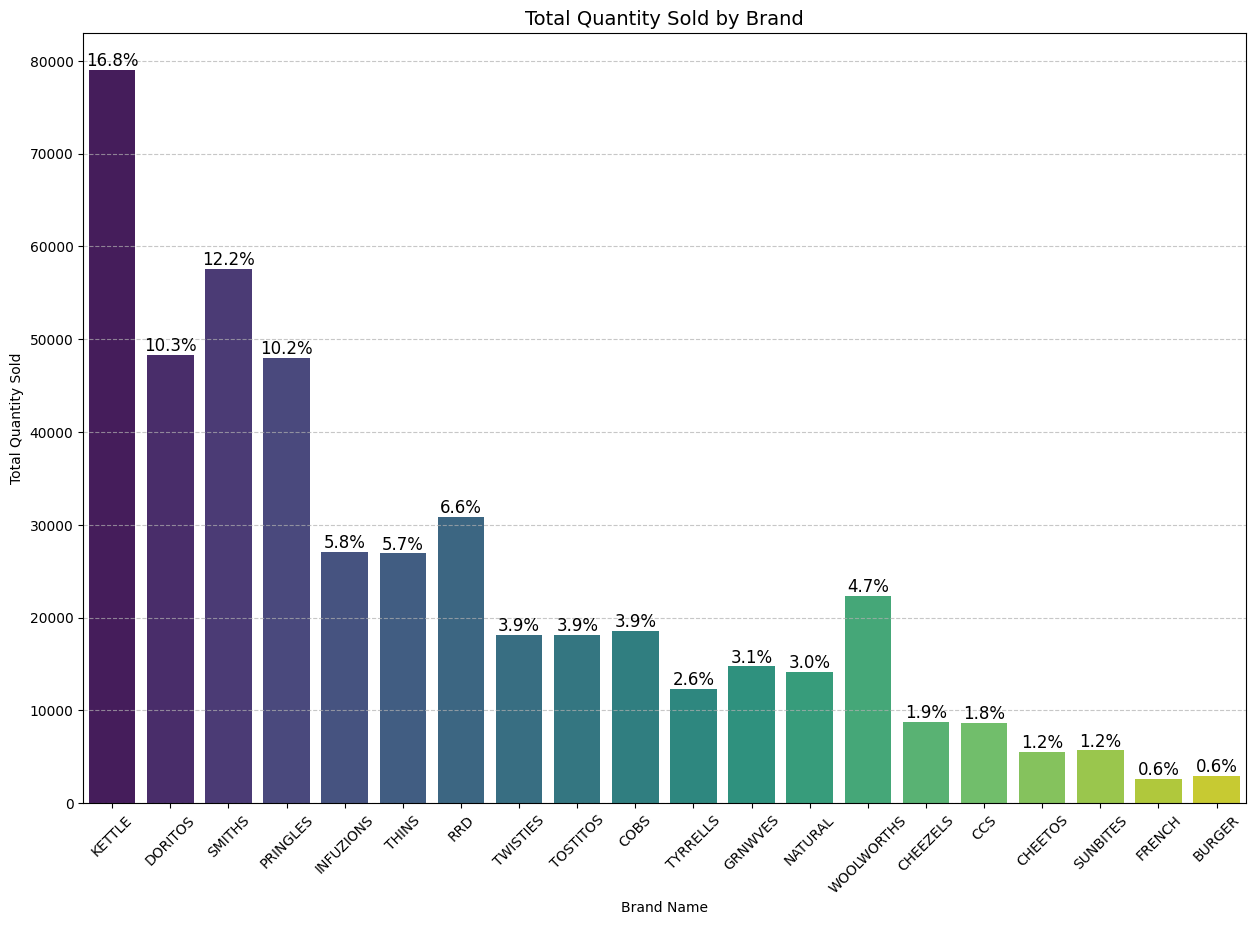

In [ ]:
# Calculate percentage share
brand_analysis["SALES_SHARE"] = (brand_analysis["TOT_SALES"] / brand_analysis["TOT_SALES"].sum()) * 100
brand_analysis["QTY_SHARE"] = (brand_analysis["PROD_QTY"] / brand_analysis["PROD_QTY"].sum()) * 100

# Figure size for better visibility
plt.figure(figsize=(15, 10))

# Bar plot for Total Revenue by Brand
ax = sns.barplot(x="BRAND", y="TOT_SALES", hue="BRAND", data=brand_analysis, palette="coolwarm", legend=False)

# Annotate bars with percentage share
for p, share in zip(ax.patches, brand_analysis["SALES_SHARE"]):
    ax.annotate(f"{share:.1f}%", (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, color='black')

plt.title("Total Revenue by Brand", fontsize=14)
plt.xlabel("Brand Name")
plt.ylabel("Total Revenue ($)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Figure size for the second graph
plt.figure(figsize=(15, 10))

# Bar plot for Total Quantity Sold by Brand
ax2 = sns.barplot(x="BRAND", y="PROD_QTY", hue="BRAND", data=brand_analysis, palette="viridis", legend=False)

# Annotate bars with percentage share
for p, share in zip(ax2.patches, brand_analysis["QTY_SHARE"]):
    ax2.annotate(f"{share:.1f}%", (p.get_x() + p.get_width() / 2, p.get_height()), 
                 ha='center', va='bottom', fontsize=12, color='black')

plt.title("Total Quantity Sold by Brand", fontsize=14)
plt.xlabel("Brand Name")
plt.ylabel("Total Quantity Sold")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
